In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [136]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [64]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [9]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [13]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [88]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

bday = calc_temps('2010-02-23', '2010-03-01')
bday


[(61.0, 68.37777777777778, 76.0)]

date range: 2010-02-23 - 2010-03-01


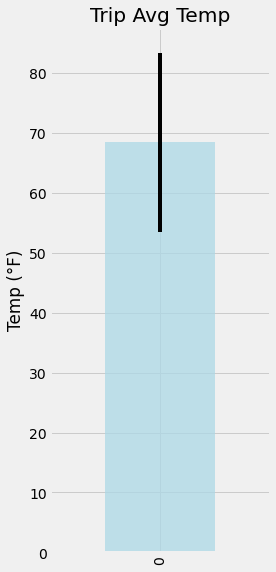

In [89]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
print(f'date range: 2010-02-23 - 2010-03-01')
df2 = pd.DataFrame({'min': bday[0][0],'avg': bday[0][1], 'max':bday[0][2]},index=[0])
min_max = df2['max'] - df2['min']
df2['avg'].plot(kind='bar', yerr=min_max, figsize=(3.5,9), alpha=0.75, color='lightblue')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (°F)")
plt.show()


### Daily Rainfall Average

In [105]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
print(f'date range: 2010-02-23 - 2010-03-01')

s_info = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation)
s_info_df = pd.DataFrame(s_info[:], columns=['station', 'name', 'latitude', 'longitude', 'elevation'])

rain_sum = session.query(Measurement.station, func.sum(Measurement.prcp)).\
    filter(Measurement.date >= '2010-02-23').\
    filter(Measurement.date <= '2010-03-01').group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
rs_df = pd.DataFrame(rain_sum[:], columns=['station', 'total rain'])
ss_df = pd.merge(rs_df, s_info_df)
# rain_sum
ss_df

date range: 2010-02-23 - 2010-03-01


,station,total rain,name,latitude,longitude,elevation
0,USC00516128,0.35,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519523,0.24,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
2,USC00519281,0.14,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00513117,0.04,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00518838,0.03,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519397,0.01,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00514830,0.01,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
7,USC00511918,0.00,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9


In [161]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("02-23")

[(62.0, 70.35593220338983, 81.0)]

In [156]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2010-02-23'
end_date = '2010-03-01'

# Use the start and end date to create a range of dates
vac_week = [d.strftime('%Y-%m-%d') for d in pd.date_range(start_date,end_date)]
print(vac_week)
print('\n')

# Strip off the year and save a list of strings in the format %m-%d
day = start_date
day = dt.strptime(day, "%Y-%m-%d")
day = day.strftime('%m-%d')
print(day)
print('\n')

d_norm = []
for day in vac_week:
    day = dt.strptime(day, '%Y-%m-%d')
    day = day.strftime('%m-%d')
    d_norm.append(day)
print(d_norm)
print('\n')

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals=[]
for norm in d_norm:
    norm = daily_normals(norm)
    normals.append(norm)
print(normals)


['2010-02-23', '2010-02-24', '2010-02-25', '2010-02-26', '2010-02-27', '2010-02-28', '2010-03-01']


02-23


['02-23', '02-24', '02-25', '02-26', '02-27', '02-28', '03-01']


[[(62.0, 70.35593220338983, 81.0)], [(61.0, 68.56666666666666, 76.0)], [(61.0, 68.59649122807018, 76.0)], [(62.0, 69.89285714285714, 78.0)], [(58.0, 69.98148148148148, 77.0)], [(65.0, 70.65517241379311, 80.0)], [(64.0, 70.0327868852459, 76.0)]]


In [185]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

data = [item[0] for item in normals]
print(data)
s_info_df = pd.DataFrame(data, columns=['tmin', 'tavg', 'tmax'])
s_info_df['date'] = vac_week
s_info_df.set_index('date', inplace=True)
s_info_df

[(62.0, 70.35593220338983, 81.0), (61.0, 68.56666666666666, 76.0), (61.0, 68.59649122807018, 76.0), (62.0, 69.89285714285714, 78.0), (58.0, 69.98148148148148, 77.0), (65.0, 70.65517241379311, 80.0), (64.0, 70.0327868852459, 76.0)]


,tmin,tavg,tmax
date,,,
2010-02-23,62.0,70.355932,81.0
2010-02-24,61.0,68.566667,76.0
2010-02-25,61.0,68.596491,76.0
2010-02-26,62.0,69.892857,78.0
2010-02-27,58.0,69.981481,77.0
2010-02-28,65.0,70.655172,80.0
2010-03-01,64.0,70.032787,76.0


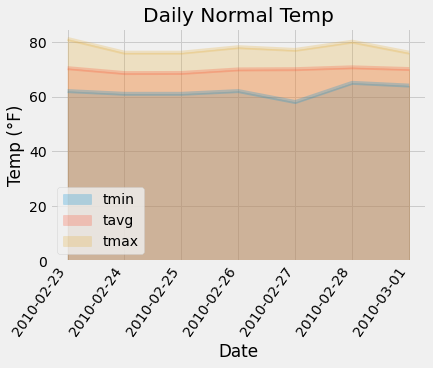

In [236]:
# Plot the daily normals as an area plot with `stacked=False`
ax = s_info_df.plot.area(stacked=False, alpha=0.25, figsize=(6,4))
plt.title("Daily Normal Temp")
# tickvalues = np.arange(0,len(s_info_df), step=1)
plt.xlabel("Date")
plt.xticks(rotation=55, ha='right')
# plt.xlim([0,6])
plt.ylabel("Temp (°F)")
plt.show()

## Close Session

In [237]:
session.close()